<a href="https://colab.research.google.com/github/wa976/DL_teamproject/blob/master/project3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 686kB 4.5MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import cv2
import os, shutil
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 원본 데이터 경로
original_dataset_dir = '/content/gdrive/My Drive/deeplearning/project/original'

# 클래스 list
classes_list = os.listdir(original_dataset_dir)

# split한 데이터를 저장할 디렉토리 지정 후 생성
base_dir = '/content/gdrive/My Drive/deeplearning/project/data_split'
os.mkdir(base_dir)

# train/validation/test 하위 폴더 생성
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)


for cls in classes_list:
    # train 하위 폴더로 클래스 별 폴더 생성
    os.mkdir(os.path.join(train_dir, cls))
    
    # validation 하위 폴더로 클래스 별 폴더 생성
    os.mkdir(os.path.join(validation_dir, cls))
    
    # test 하위 폴더로 클래스 별 폴더 생성
    os.mkdir(os.path.join(test_dir, cls))

In [ ]:
import math

for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
    # 데이터 나눌 비율 지정 (6:2:2)
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]
    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

In [ ]:
# Directories
train_directory = "/content/gdrive/My Drive/deeplearning/project/data_split/train"
valid_directory =  "/content/gdrive/My Drive/deeplearning/project/data_split/validation"
test_directory =  "/content/gdrive/My Drive/deeplearning/project/data_split/test"
# Constants
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 10
batch_size = 16
num_of_classes = 28
num_of_train_samples = 888
num_of_valid_samples = 292
num_of_test_samples = 292


# Load Train Data as image generator with Keras, Normalization with (rescale=1./255)
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load Validation Data as image generator with Keras, Normalization with (rescale=1./255)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                        class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                        target_size=(img_rows, img_cols),
                                                                        color_mode="rgb",
                                                                         shuffle=True)

# Load Test Data as image generator with Keras, Normalization with (rescale=1./255)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=test_directory, 
                                                                        class_mode='categorical', 
                                                                        batch_size=batch_size,
                                                                        target_size=(img_rows, img_cols),
                                                                        color_mode="rgb",
                                                                        shuffle=False)

Found 888 images belonging to 28 classes.
Found 292 images belonging to 28 classes.
Found 292 images belonging to 28 classes.


In [ ]:
# Get VGG-16 Model
def getVGG16Model(lastFourTrainable=False):
  vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=True)

  # Make all layers untrainable
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = vgg_model.get_layer('fc2').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=28, activation='softmax',)(output)
  vgg_model = Model(vgg_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    vgg_model.get_layer('block5_conv3').trainable = True
    vgg_model.get_layer('fc1').trainable = True
    vgg_model.get_layer('fc2').trainable = True
    vgg_model.get_layer('new_fc').trainable = True

  # Compile VGG-16 model
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model



In [ ]:
def trainModel(model):
  # Fit the model
  model.fit_generator(train_generator,
                      epochs=epochs,
                      steps_per_epoch=num_of_train_samples // batch_size,
                      validation_data=valid_generator,
                      validation_steps=num_of_valid_samples // batch_size)

  # Evaluate the model
  loss_and_metrics = model.evaluate_generator(test_generator, steps=num_of_test_samples // batch_size+1)
  print("Test Loss: ", loss_and_metrics[0])
  print("Test Accuracy: ", loss_and_metrics[1])
  test_generator.reset()

  return model

In [ ]:
# Get VGG-16 Model with lastFourTrainable=False
vgg_model_a = getVGG16Model(lastFourTrainable=False)
# Train VGG-16 Model 
vgg_model_a = trainModel(vgg_model_a)
vgg_model_a.save_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_nontrainable.h5')



553476096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 5.6877 - accuracy: 0.0753

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (126387000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


55/55 [==============================] - 403s 7s/step - loss: 5.6625 - accuracy: 0.0764 - val_loss: 2.8753 - val_accuracy: 0.2535
Epoch 2/10
55/55 [==============================] - 31s 563ms/step - loss: 2.7045 - accuracy: 0.2590 - val_loss: 2.4041 - val_accuracy: 0.2882
Epoch 3/10
55/55 [==============================] - 31s 562ms/step - loss: 2.1442 - accuracy: 0.3841 - val_loss: 2.0188 - val_accuracy: 0.4340
Epoch 4/10
55/55 [==============================] - 31s 567ms/step - loss: 1.7395 - accuracy: 0.5131 - val_loss: 1.7638 - val_accuracy: 0.5035
Epoch 5/10
55/55 [==============================] - 31s 571ms/step - loss: 1.4326 - accuracy: 0.6041 - val_loss: 1.8480 - val_accuracy: 0.4410
Epoch 6/10
55/55 [==============================] - 31s 566ms/step - loss: 1.3325 - accuracy: 0.6147 - val_loss: 1.5228 - val_accuracy: 0.5382
Epoch 7/10
55/55 [==============================] - 31s 568ms/step - loss: 1.1637 - accuracy: 0.6391 - val_loss: 1.5708 - val_accuracy: 0.5243
Epoch 8/10
5

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss:  1.4244495630264282
Test Accuracy:  0.5993150472640991


In [ ]:
# Get VGG-16 Model with lastFourTrainable=True
vgg_model_b = getVGG16Model(lastFourTrainable=True)
# Train VGG-16 Model
vgg_model_b = trainModel(vgg_model_b)
vgg_model_b.save_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_trainable.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
55/55 [==============================] - ETA: 0s - loss: 7.9257 - accuracy: 0.0296

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (126387000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


55/55 [==============================] - 36s 627ms/step - loss: 7.8696 - accuracy: 0.0297 - val_loss: 3.3361 - val_accuracy: 0.0660
Epoch 2/10
55/55 [==============================] - 32s 592ms/step - loss: 3.2745 - accuracy: 0.0618 - val_loss: 2.6872 - val_accuracy: 0.1528
Epoch 3/10
55/55 [==============================] - 32s 575ms/step - loss: 2.5610 - accuracy: 0.1954 - val_loss: 2.2035 - val_accuracy: 0.2951
Epoch 4/10
55/55 [==============================] - 31s 569ms/step - loss: 1.5494 - accuracy: 0.4773 - val_loss: 1.7909 - val_accuracy: 0.4861
Epoch 5/10
55/55 [==============================] - 32s 583ms/step - loss: 0.9477 - accuracy: 0.7065 - val_loss: 2.4180 - val_accuracy: 0.4722
Epoch 6/10
55/55 [==============================] - 32s 581ms/step - loss: 0.7719 - accuracy: 0.7811 - val_loss: 1.4364 - val_accuracy: 0.6042
Epoch 7/10
55/55 [==============================] - 32s 585ms/step - loss: 0.4089 - accuracy: 0.8781 - val_loss: 1.5539 - val_accuracy: 0.6319
Epoch 8/10

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Loss:  1.6161348819732666
Test Accuracy:  0.6952054500579834


In [ ]:
# # Get ResNet-50 Model
# def getResNet50Model(lastFourTrainable=False):
#   resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)

#   # Make all layers non-trainable
#   for layer in resnet_model.layers[:]:
#       layer.trainable = False


#   # Add fully connected layer which have 1024 neuron to ResNet-50 model
#   output = resnet_model.get_layer('conv5_block3_out').output
#   output = GlobalAveragePooling2D(input_shape=(7*7*2045,0))(output)
#   output = Flatten(name='new_flatten')(output)
#   output = Dense(units=1000, activation='relu', name='new_fc')(output)
#   output = Dense(units=28, activation='softmax')(output)
#   resnet_model = Model(resnet_model.input, output)

#   # Make last 4 layers trainable if lastFourTrainable == True
#   if lastFourTrainable == True:
#     resnet_model.get_layer('conv5_block3_2_bn').trainable = True
#     resnet_model.get_layer('conv5_block3_3_conv').trainable = True
#     resnet_model.get_layer('conv5_block3_3_bn').trainable = True
#     #resnet_model.get_layer('new_fc').trainable = True

#   # Compile ResNet-50 model
#   resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#   resnet_model.summary()
  
#   return resnet_model

In [ ]:
# # Get ResNet-50 Model with lastFourTrainable=False
# resnet_model_a = getResNet50Model(lastFourTrainable=False)
# # Train ResNet-50 Model and get Confusion Matrix
# resnet_model_a = trainModel(resnet_model_a)
# resnet_model_a.save_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_nontrainable.h5')

In [ ]:
#  # Get ResNet-50 Model with lastFourTrainable=True
#  resnet_model_b = getResNet50Model(lastFourTrainable=True)
#  # Train ResNet-50 Model and get Confusion Matrix
#  resnet_model_b = trainModel(resnet_model_b)
#  resnet_model_b.save_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_trainable.h5')

In [ ]:
# Get feature vector of an image by given model and img_path
def getFeatureVector(model, img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  feature_vector = model.predict(img.reshape(1, 224, 224, 3))
  return feature_vector


# Get cosine similarity between feature vectors A and B using cosine similarity
def getCosineSimilarity(A, B):
  cos_similarity = np.dot(A,B.T) / (np.linalg.norm(A)*np.linalg.norm(B)) # Get cosine similarity
  return cos_similarity[0][0]


# Function for get dataframe which contains the output features of given model
def getFeatureDataFrame(model):
  df = pd.DataFrame(columns=['file', 'features'])
  train_files = train_generator.filepaths
  valid_files = valid_generator.filepaths
  files = train_files + valid_files

  df['file'] = files
  df['features'] = df.apply(lambda row: getFeatureVector(model, row['file']), axis=1) 

  print("All files added.")
  return df

# Plot similar 5 images with given image and similar images dataframe
def plotSimilarImages(img_file, similar_df, model_name):
  img = cv2.imread(img_file)
  img = cv2.resize(img, (224, 224))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  split_list = img_file.split('/')
  split_list.reverse()
  img_class = split_list[1]
  fig, axarr = plt.subplots(2,3)
  axarr[0,0].imshow(img)
  axarr[0,0].set_title("TEST IMAGE - " + model_name + "\nClass: " + img_class)
  axarr[0,0].axis('off')


  j, k, m = 0, 0, 1
  for index, sim in similar_df.iterrows():
    filepath = sim['file']
    similarity = sim['similarity']
    split_list = filepath.split('/')
    split_list.reverse()
    sim_class = split_list[1]

    similar = cv2.imread(filepath)
    similar = cv2.resize(similar, (224, 224))
    similar = cv2.cvtColor(similar, cv2.COLOR_BGR2RGB)
    axarr[k,m].imshow(similar)
    axarr[k,m].set_title("Similarity: %.3f" % similarity + "\nClass: " + sim_class)
    axarr[k,m].axis('off')

    m += 1
    if m == 3 and k != 1:
      k += 1
      m = 0

    j += 1
    if j == 5:
      break

  plt.tight_layout()
  plt.show()



# Get and plot 5 similar images for given image path and features dataframe
def getSimilarImages(img_file, features_df, model, model_name):
  img_features = getFeatureVector(model, img_file)
  features_df['similarity'] = features_df.apply(lambda row: getCosineSimilarity(img_features, np.asarray(row['features'])), axis=1)  
  sorted_df = features_df.sort_values(by='similarity', ascending=False)  
  plotSimilarImages(img_file, sorted_df.head(5), model_name) #head(5)를 조절하여 순위 결정

In [ ]:
# Get feature extractor model from last layer of vgg_model_a
vgg_model_a = getVGG16Model(lastFourTrainable=False)
vgg_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_nontrainable.h5')
feature_model_vgg_a_a = Model(inputs=vgg_model_a.input, outputs=vgg_model_a.get_layer('new_fc').output)

df = getFeatureDataFrame(feature_model_vgg_a_a)
df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_vgg_a_a.pickle")


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Get feature extractor model from second from last of vgg_model_a
vgg_model_a = getVGG16Model(lastFourTrainable=False)
vgg_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_nontrainable.h5')
feature_model_vgg_a_b = Model(inputs=vgg_model_a.input, outputs=vgg_model_a.get_layer('fc2').output)

df = getFeatureDataFrame(feature_model_vgg_a_b)
df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_vgg_a_b.pickle")



Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
vgg_model_b = getVGG16Model(lastFourTrainable=True)
vgg_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_trainable.h5')
feature_model_vgg_b_a = Model(inputs=vgg_model_b.input, outputs=vgg_model_b.get_layer('new_fc').output)

df = getFeatureDataFrame(feature_model_vgg_b_a)
df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_vgg_b_a.pickle")

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
vgg_model_b = getVGG16Model(lastFourTrainable=True)
vgg_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_trainable.h5')
feature_model_vgg_b_b = Model(inputs=vgg_model_b.input, outputs=vgg_model_b.get_layer('fc2').output)

df = getFeatureDataFrame(feature_model_vgg_b_b)
df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_vgg_b_b.pickle")

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# resnet_model_a = getResNet50Model(lastFourTrainable=False)
# resnet_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_nontrainable.h5')
# feature_model_resnet_a = Model(inputs=resnet_model_a.input, outputs=resnet_model_a.get_layer('new_fc').output)

# df = getFeatureDataFrame(feature_model_resnet_a)
# df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_resnet_a.pickle")



In [ ]:
# # Get feature extractor model from last layer of resnet_model_b
# resnet_model_b = getResNet50Model(lastFourTrainable=True)
# resnet_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_trainable.h5')
# feature_model_resnet_b = Model(inputs=resnet_model_b.input, outputs=resnet_model_b.get_layer('new_fc').output)

# df = getFeatureDataFrame(feature_model_resnet_b)
# df.to_pickle("/content/gdrive/My Drive/deeplearning/project/features_resnet_b.pickle")



In [ ]:
# Test images path
feature_test_path = '/content/gdrive/My Drive/deeplearning/project/feature_test'
feature_test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=feature_test_path,
                                                                  class_mode='categorical',
                                                                  batch_size=batch_size,
                                                                  target_size=(img_rows, img_cols),
                                                                  color_mode="rgb",
                                                                  shuffle=False)
feature_test_files = feature_test_generator.filepaths

Found 6 images belonging to 6 classes.


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

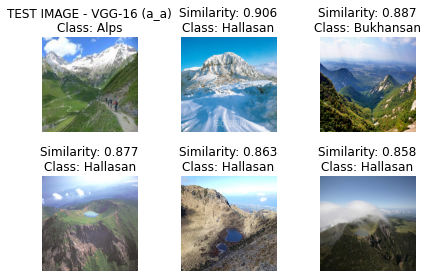

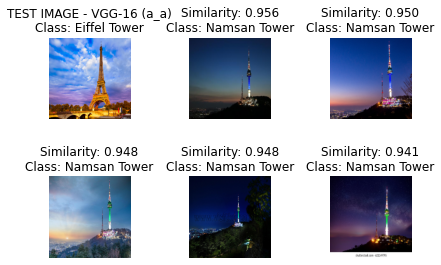

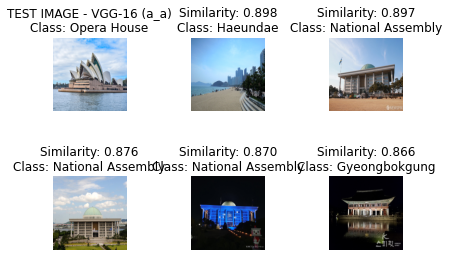

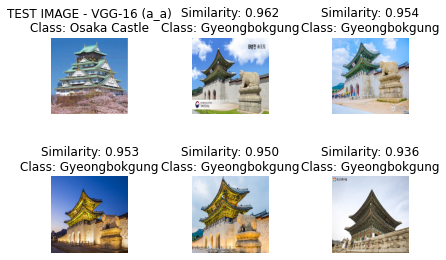

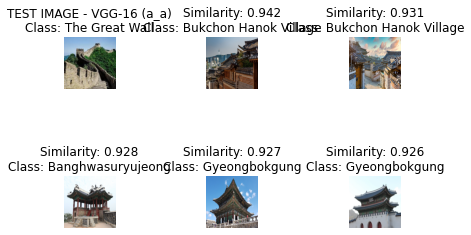

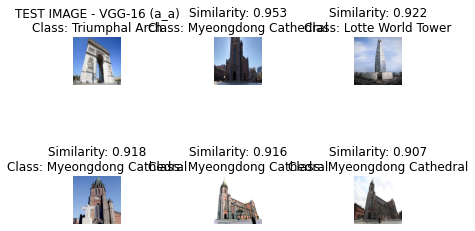

In [ ]:
# Get similar images of test images for VGG-16 (a_a)

vgg_model_a = getVGG16Model(lastFourTrainable=False)
vgg_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_nontrainable.h5')
feature_model_vgg_a_a = Model(inputs=vgg_model_a.input, outputs=vgg_model_a.get_layer('new_fc').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_vgg_a_a.pickle')


for file in feature_test_files:
  getSimilarImages(file, df, feature_model_vgg_a_a, 'VGG-16 (a_a)')



Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

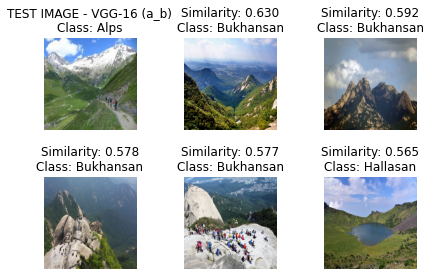

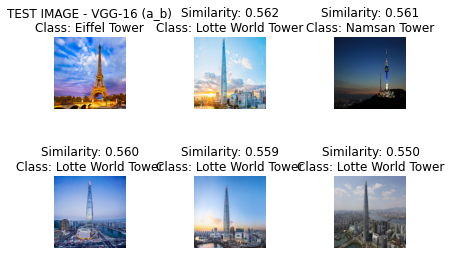

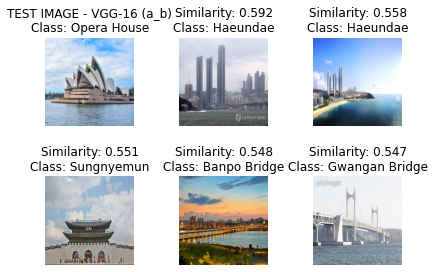

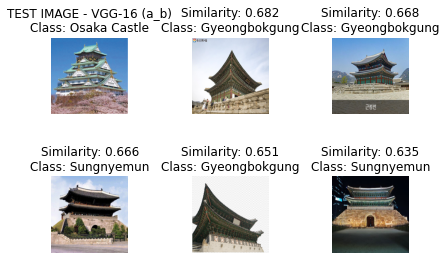

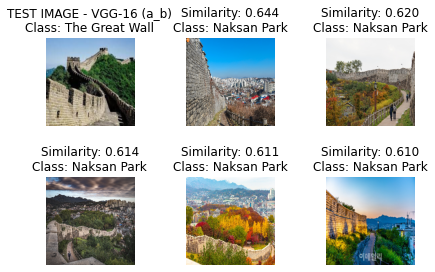

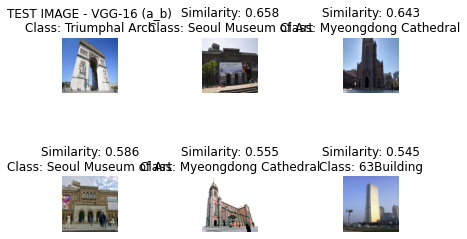

In [ ]:
# Get similar images of test images for VGG-16 (a_b)

vgg_model_a = getVGG16Model(lastFourTrainable=False)
vgg_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_nontrainable.h5')
feature_model_vgg_a_b = Model(inputs=vgg_model_a.input, outputs=vgg_model_a.get_layer('fc2').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_vgg_a_b.pickle')


for file in feature_test_files:
  getSimilarImages(file, df, feature_model_vgg_a_b, 'VGG-16 (a_b)')

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

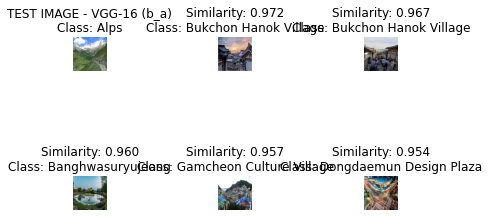

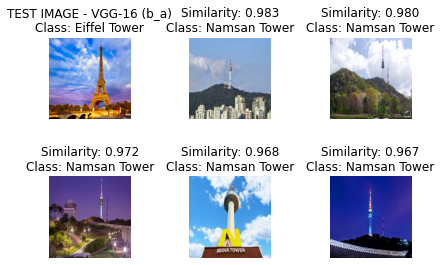

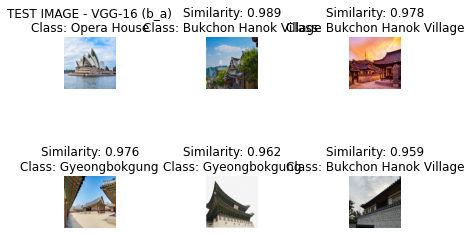

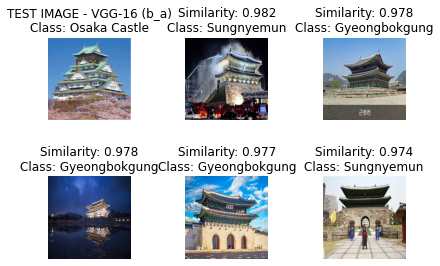

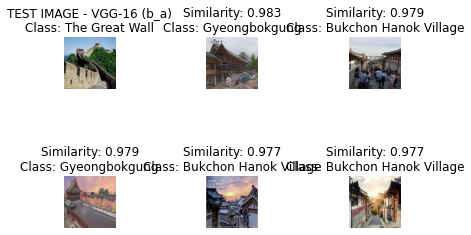

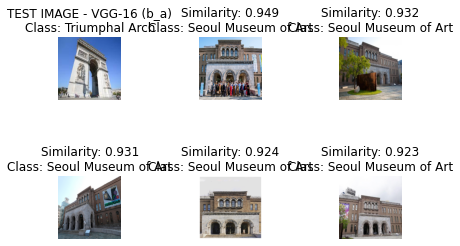

In [ ]:
# Get similar images of test images for VGG-16 (b_a)
vgg_model_b = getVGG16Model(lastFourTrainable=True)
vgg_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_trainable.h5')
feature_model_vgg_b_a = Model(inputs=vgg_model_b.input, outputs=vgg_model_b.get_layer('new_fc').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_vgg_b_a.pickle')
for file in feature_test_files:
  getSimilarImages(file, df, feature_model_vgg_b_a, 'VGG-16 (b_a)')

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

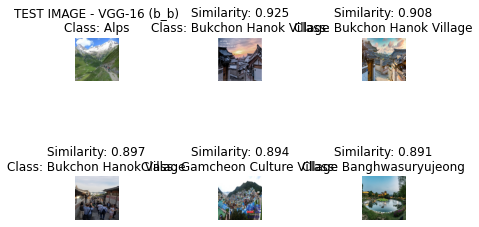

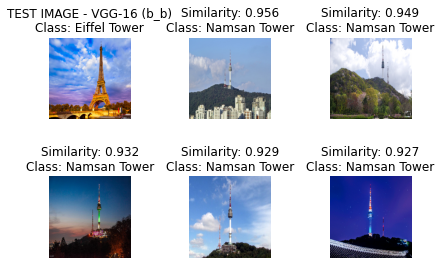

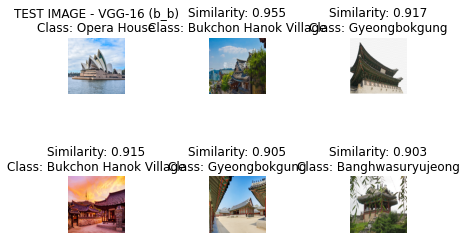

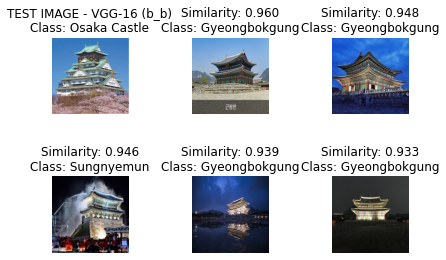

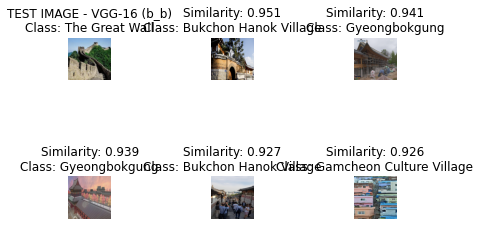

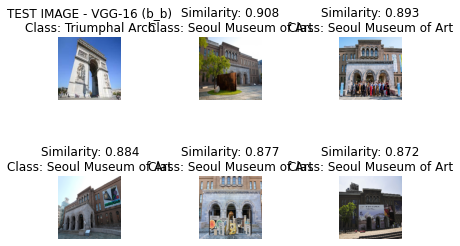

In [ ]:
# Get similar images of test images for VGG-16 (b_b)
vgg_model_b = getVGG16Model(lastFourTrainable=True)
vgg_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_trainable.h5')
feature_model_vgg_b_a = Model(inputs=vgg_model_b.input, outputs=vgg_model_b.get_layer('fc2').output)

df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_vgg_b_b.pickle')
for file in feature_test_files:
  getSimilarImages(file, df, feature_model_vgg_b_b, 'VGG-16 (b_b)')

In [ ]:
# # Get similar images of test images for ResNet-50 (a)
# resnet_model_a = getResNet50Model(lastFourTrainable=False)
# resnet_model_a.load_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_nontrainable.h5')
# feature_model_resnet_a = Model(inputs=resnet_model_a.input, outputs=resnet_model_a.get_layer('new_fc').output)

# df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_resnet_a.pickle')
# for file in feature_test_files:
#   getSimilarImages(file, df, feature_model_resnet_a, 'ResNet-50 (a)')

In [ ]:
# # Get similar images of test images for ResNet-50 (b)
# resnet_model_b = getResNet50Model(lastFourTrainable=True)
# resnet_model_b.load_weights('/content/gdrive/My Drive/deeplearning/project/model_resnet_trainable.h5')
# feature_model_resnet_b = Model(inputs=resnet_model_b.input, outputs=resnet_model_b.get_layer('new_fc').output)

# df = pd.read_pickle('/content/gdrive/My Drive/deeplearning/project/features_resnet_b.pickle')
# for file in feature_test_files:
#   getSimilarImages(file, df, feature_model_resnet_b, 'ResNet-50 (b)')

In [ ]:
def getVGG16Model_TripletLoss(lastFourTrainable=False):
  vgg_model = VGG16(weights='imagenet', input_shape=input_shape, include_top=True)

  # Make all layers untrainable
  for layer in vgg_model.layers[:]:
      layer.trainable = False

  # Add fully connected layer which have 1024 neuron to VGG-16 model
  output = vgg_model.get_layer('fc2').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=28, activation=None)(output)
  output = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
  (lambda x: 2*x, name='lambda')
  vgg_model = Model(vgg_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    vgg_model.get_layer('block5_conv3').trainable = True
    vgg_model.get_layer('fc1').trainable = True
    vgg_model.get_layer('fc2').trainable = True
    vgg_model.get_layer('new_fc').trainable = True

  # Compile VGG-16 model
  vgg_model.compile(optimizer='adam', loss='TripletSemiHardLoss', metrics=['accuracy'])
  vgg_model.summary()

  return vgg_model


In [ ]:
# Get VGG-16 Model with lastFourTrainable=False
vgg_model_c = getVGG16Model_TripletLoss(lastFourTrainable=False)
# Train VGG-16 Model 
vgg_model_c = trainModel(vgg_model_c)
vgg_model_c.save_weights('/content/gdrive/My Drive/deeplearning/project/model_vgg_Triplet.h5')


ValueError: ignored